In [33]:
from transformers import AutoImageProcessor, SuperPointForKeypointDetection
import torch
from PIL import Image
import requests

import random

import numpy as np
import matplotlib.pyplot as plt
import cv2

In [49]:
processor = AutoImageProcessor.from_pretrained("magic-leap-community/superpoint")
model = SuperPointForKeypointDetection.from_pretrained("magic-leap-community/superpoint")

def compute_keypoints(img):
    inputs = processor(img, return_tensors="pt")
    outputs = model(**inputs)
    return outputs['keypoints'].detach().squeeze(0).cpu().numpy().astype(np.float32), outputs['descriptors'].detach().squeeze(0).cpu().numpy().astype(np.float32)


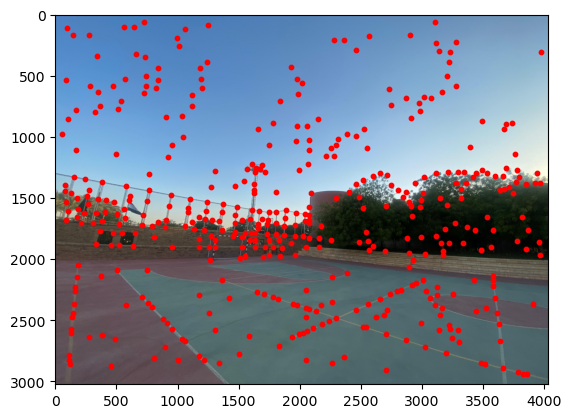

In [50]:
img = Image.open('data/left_12.jpeg')
kpts, descs = compute_keypoints(img)

kpts = kpts * np.array([img.size[0], img.size[1]])
plt.imshow(img);
plt.scatter(kpts[:, 0], kpts[:, 1], c='r', s=10);

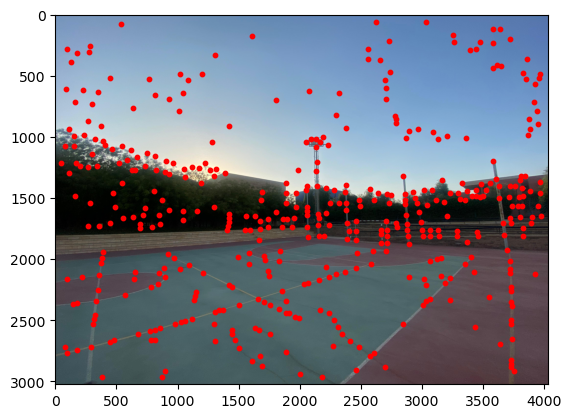

In [66]:
img = Image.open('data/right_12.jpeg')
kpts, descs = compute_keypoints(img)

kpts = kpts * np.array([img.size[0], img.size[1]])
plt.imshow(img);
plt.scatter(kpts[:, 0], kpts[:, 1], c='r', s=10);

Found 5 good matches.


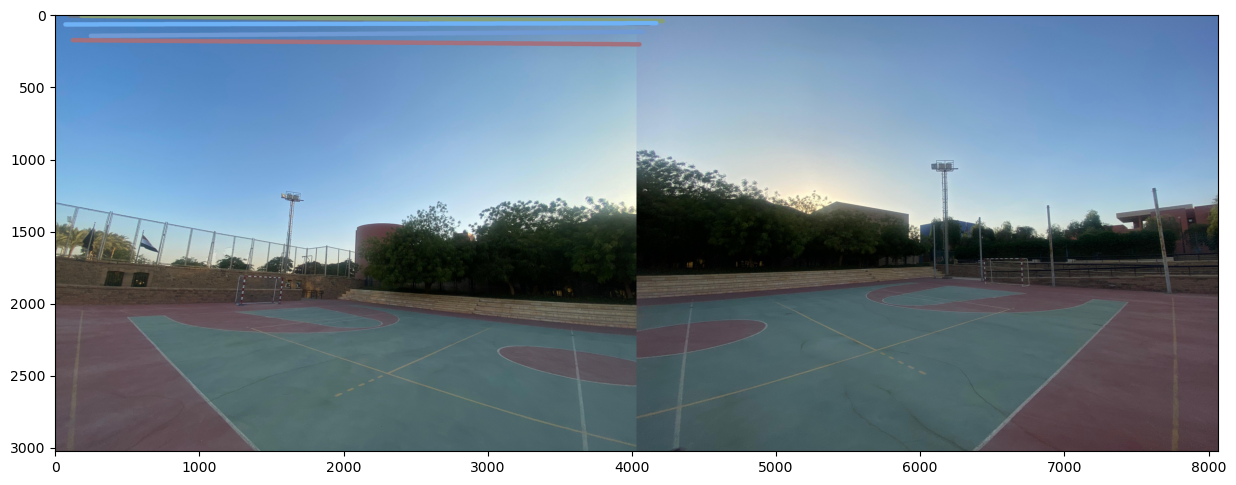

In [65]:
img1 = plt.imread('data/left_12.jpeg')
img2 = plt.imread('data/right_12.jpeg')

h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]

kpts1, descs1 = compute_keypoints(img1)
kpts2, descs2 = compute_keypoints(img2)

kpts1_pixels = kpts1 * np.array([w1, h1])
kpts2_pixels = kpts2 * np.array([w2, h2])

# === Match descriptors using Lowe's ratio test ===
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
matches = bf.knnMatch(descs1, descs2, k=2)

# Apply Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.6 * n.distance:
        good_matches.append(m)

print(f"Found {len(good_matches)} good matches.")

# === Draw matches ===
match_img = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
match_img[:h1, :w1] = img1
match_img[:h2, w1:] = img2
for match in good_matches:
    pt1 = tuple(np.round(kpts1_pixels[match.queryIdx]).astype(np.uint8))
    pt2 = tuple(np.round(kpts2_pixels[match.trainIdx]).astype(np.uint8) + np.array([w1, 0]))

    color = tuple([random.randint(100, 255) for _ in range(3)])
    cv2.circle(match_img, pt1, 5, color, -1)
    cv2.circle(match_img, pt2, 5, color, -1)
    cv2.line(match_img, pt1, pt2, color, 30)

plt.figure(figsize=(15, 8))
plt.imshow(match_img);